# 0. Импорты и подготовка данных

In [2]:
!pip install transformers[torch]
#!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [48]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification, AutoModelForTokenClassification,
    AutoTokenizer, TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split

In [4]:
# установление максимальной длины последовательности для токенизатора необходимо,
# т. к. каждому слову может соответствовать последовательность токенов разной длины,
# а для корректного формирования минибатчей тензоры для каждого слова
# должны быть одной длины
PADDING_MAX_LENGTH = 32

### Размеченные данные

Загрузим размеченные данные и подготовим их к работе. Для дообучения трансформера будем использовать размеченную выборку, размер которой составляет около 5 000 токенов. Размеченная выборка представляет собой датафрейм, который включает 2 столбца: word и label. В первом столбце содержатся токены, во втором - метка булевого типа, где 1 обозначает, что токен относится к области сенсорной лексики, а 0 - не относится.

In [ ]:
labeled_words = pd.read_excel("train_set.xlsx")

In [ ]:
labeled_words

,Tаблица 1,Unnamed: 1
0,word,label
1,Очень,0
2,привередливый,0
3,аромат,1
4,.,0
...,...,...
5676,запах,1
5677,свежескошенной,0
5678,травы,1
5679,идеально,0


In [ ]:
labeled_words.columns = labeled_words.iloc[0]
labeled_words = labeled_words.iloc[1:]

In [ ]:
labeled_words

,word,label
1,Очень,0
2,привередливый,0
3,аромат,1
4,.,0
5,Разнашивали,0
...,...,...
5676,запах,1
5677,свежескошенной,0
5678,травы,1
5679,идеально,0


In [ ]:
labeled_words = labeled_words.dropna()

In [ ]:
labeled_words

,word,label
1,Очень,0
2,привередливый,0
3,аромат,1
4,.,0
5,Разнашивали,0
...,...,...
5676,запах,1
5677,свежескошенной,0
5678,травы,1
5679,идеально,0


In [ ]:
mystem = Mystem()

def lemmatize_text(text):
    lemmatized_text = []
    for sentence in text:
        lemmas = mystem.lemmatize(sentence)
        lemmas = [lemma for lemma in lemmas if lemma[0].isalpha()]
        lemmatized_text.append(' '.join(lemmas))
    return lemmatized_text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
labeled_words['word'] = labeled_words['word'].apply(lambda x: mystem.lemmatize(str(x))[0])

<ipython-input-11-fcb83ac3f1ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_words['word'] = labeled_words['word'].apply(lambda x: mystem.lemmatize(str(x))[0])


In [ ]:
labeled_words

,word,label
1,очень,0
2,привередливый,0
3,аромат,1
4,.,0
5,разнашивать,0
...,...,...
5676,запах,1
5677,свежескошенный,0
5678,трава,1
5679,идеально,0


### Распределение меток в данных

In [ ]:
import matplotlib.pyplot as plt

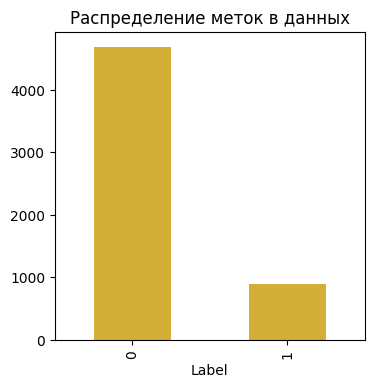

In [ ]:
label_counts = labeled_words.groupby('label').size()
plt.figure(figsize=(4, 4))
label_counts.plot(kind='bar', color='#d4af37')
plt.title('Распределение меток в данных')
plt.xlabel('Label')
plt.xticks([0, 1], ['0', '1'])
plt.show()

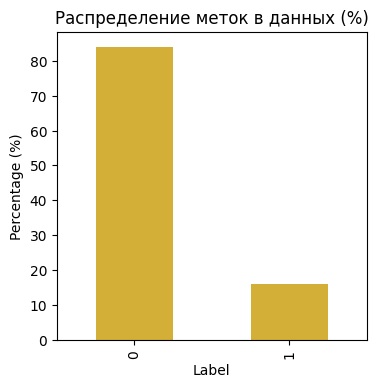

In [ ]:
label_percentages = (label_counts / label_counts.sum()) * 100
plt.figure(figsize=(4, 4))
label_percentages.plot(kind='bar', color='#d4af37')
plt.title('Распределение меток в данных (%)')
plt.xlabel('Label')
plt.xticks([0, 1], ['0', '1'])
plt.ylabel('Percentage (%)')
plt.show()

In [ ]:
label_percentages

label
0    84.112484
1    15.887516
dtype: float64

# 1. DistilBERT

### Эксперимент 1: 3 эпохи, lr = 2e-5

Размеченные данные делим на train, test, validation set в соотношении 80 - 10 - 10. Такое соотношение зарекомендовало себя в том числе и при работе с относительно небольшими выборками.

In [ ]:
words = list(labeled_words["word"])
labels = list(labeled_words["label"])

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(words, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [ ]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(set(y_train)))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

Реализуем пользовательский датасет для задачи бинарной классификации на основе PyTorch Dataset. Этот шаг необходим, чтобы обеспечить успешный вход данных в модель.

In [ ]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, words, labels, tokenizer, max_length=128):
        # валидация входа
        if not len(words) == len(labels):
            raise ValueError('words and labels must have the same length')

        self.words = words
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            word,
            truncation=True,
            padding='max_length',
            max_length=PADDING_MAX_LENGTH,
            return_tensors='pt' #возвращение энкодингов в формате тензоров PyTorch
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long).reshape(1)
        }

Создадим объекты BinaryClassificationDataset для тренировочного, тестового и валидационного наборов, используя нужные нам входные данные и токенизатор.

In [ ]:
train_dataset = BinaryClassificationDataset(X_train, y_train, tokenizer)
test_dataset = BinaryClassificationDataset(X_test, y_test, tokenizer)
val_dataset = BinaryClassificationDataset(X_val, y_val, tokenizer)

In [ ]:
train_dataset.words[1]

'и'

In [ ]:
train_dataset.labels[1]

0

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  1188, 29747, 29750, 14150, 29742, 10325, 22919, 23742,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0])}

In [ ]:
for key, tensor in train_dataset[0].items():
    print(f"{key}: {tensor.size()}")

input_ids: torch.Size([32])
attention_mask: torch.Size([32])
labels: torch.Size([1])


In [ ]:
batch_size = 4

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch", # оцениваем каждую эпоху
    learning_rate=2e-5, # темп обучения
    per_device_train_batch_size=batch_size, # размер тренировочного батча на каждый процессор
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, # количество эпох
    weight_decay=0.01, # регуляризация функции потерь
    push_to_hub=False, # не публиковать на Huggingface
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Используем DataCollator, который подойдёт для нашей задачи (классификация каждого отдельного токена): DataCollatorForTokenClassification.

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer, padding='max_length', max_length=PADDING_MAX_LENGTH,
    return_tensors='pt'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.372300,0.326051


Epoch,Training Loss,Validation Loss
1,0.372300,0.326051
2,0.308400,0.321302
3,0.240900,0.321442


TrainOutput(global_step=3351, training_loss=0.3147833222810705, metrics={'train_runtime': 5377.465, 'train_samples_per_second': 2.492, 'train_steps_per_second': 0.623, 'total_flos': 109405639639296.0, 'train_loss': 0.3147833222810705, 'epoch': 3.0})

#### Вывод по результатам обучения
1. Epoch 1: Training Loss = 0.372300, Validation Loss = 0.326051

2. Epoch 2: Training Loss = 0.308400, Validation Loss = 0.321302
   - Training Loss уменьшился, что говорит об улучшении обучения модели.
   - Validation Loss также уменьшился, что указывает на то, что модель продолжает успешно обучаться.

3. Epoch 3: Training Loss = 0.240900, Validation Loss = 0.321442
   - Training Loss продолжает уменьшаться, что свидетельствует о дальнейшем улучшении обучения.
   - Validation Loss немного увеличился, что может указывать на начало переобучения модели.

Модель постепенно обучается, но увеличивать количество эпох при таком размере выборки, кажется, не стоит. Этот факт вполне объясним: наша размеченная выборка не очень велика, соответственно достаточно быстро модель начнет переобучаться на тренировочном множестве. Общее время обучения в 3 эпохи: 1,5 часа.

#### Тест

In [ ]:
# Запустить модель на тестовом наборе данных
test_output = trainer.predict(test_dataset)

In [ ]:
print(test_output)

PredictionOutput(predictions=array([[[ 3.7359428 , -4.389942  ],
        [ 3.4628892 , -4.1597815 ],
        [ 3.3698754 , -4.190154  ],
        ...,
        [ 3.4881158 , -4.2600594 ],
        [ 3.560462  , -4.2911606 ],
        [ 3.5644677 , -4.250073  ]],

       [[ 2.04945   , -1.7323271 ],
        [ 1.7719479 , -1.3509259 ],
        [ 1.6577656 , -1.1123594 ],
        ...,
        [-0.35636085,  0.7630871 ],
        [ 0.22201344,  0.20150506],
        [ 0.4433145 , -0.42623293]],

       [[ 3.9731047 , -4.8021655 ],
        [ 3.6022563 , -4.540674  ],
        [ 3.6029654 , -4.557472  ],
        ...,
        [ 3.665814  , -4.685128  ],
        [ 3.8484764 , -4.755722  ],
        [ 3.7318685 , -4.7763824 ]],

       ...,

       [[ 4.261021  , -5.1408014 ],
        [ 3.6380334 , -4.8038287 ],
        [ 3.3075223 , -4.26793   ],
        ...,
        [ 3.8135393 , -5.0230904 ],
        [ 3.9036498 , -5.025532  ],
        [ 3.7189255 , -4.9542465 ]],

       [[ 2.856595  , -3.0159733 ]

Превратим полученный массив в список списков.

In [ ]:
predictions = test_output.predictions.tolist()

Зададим цикл для создания списка с предсказанными моделью значениями.

In [ ]:
y_pred = []
for result in predictions:  # Проходимся по каждому списку в list_of_results
    if result[0] > result[1]:  # Сравниваем первое и второе число в списке
        y_pred.append(0)  # Если первое число больше, записываем 0 в y_pred
    else:
        y_pred.append(1)  # Иначе записываем 1 в y_pred

In [ ]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       477
           1       0.78      0.73      0.75        82

    accuracy                           0.93       559
   macro avg       0.87      0.85      0.86       559
weighted avg       0.93      0.93      0.93       559



#### Вывод по результатам тестирования
- F1-score для класса 0 (слов, которые не включаются в класс сенсорной лексики) - 0.96, что означает хорошее сочетание точности и полноты для этого класса.
- F1-score для класса 1 (целевой класс, слова, которые мы относим к классу сенсорной лексики) - 0.75, показатель более низкий.

Однако я не считаю этот результат неудовлетворительным, классы не сбалансированны ввиду специфики целевого класса. Напомню, что соотношение меток в размеченных данных -- это 16 и 84 процентов для классов 1 и 0 соответственно.


### Эксперимент 2: 2 эпохи, lr = 2e-5

In [ ]:
words = list(labeled_words["word"])
labels = list(labeled_words["label"])

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(words, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [ ]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(set(y_train)))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

Реализуем пользовательский датасет для задачи бинарной классификации на основе PyTorch Dataset. Этот шаг необходим, чтобы обеспечить успешный вход данных в модель.

In [ ]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, words, labels, tokenizer, max_length=128):
        # валидация входа
        if not len(words) == len(labels):
            raise ValueError('words and labels must have the same length')

        self.words = words
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            word,
            truncation=True,
            padding='max_length',
            max_length=PADDING_MAX_LENGTH,
            return_tensors='pt' #возвращение энкодингов в формате тензоров PyTorch
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long).reshape(1)
        }

Создадим объекты BinaryClassificationDataset для тренировочного, тестового и валидационного наборов, используя нужные нам входные данные и токенизатор.

In [ ]:
train_dataset = BinaryClassificationDataset(X_train, y_train, tokenizer)
test_dataset = BinaryClassificationDataset(X_test, y_test, tokenizer)
val_dataset = BinaryClassificationDataset(X_val, y_val, tokenizer)

In [ ]:
train_dataset.words[1]

'и'

In [ ]:
train_dataset.labels[1]

0

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  1188, 29747, 29750, 14150, 29742, 10325, 22919, 23742,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0])}

In [ ]:
for key, tensor in train_dataset[0].items():
    print(f"{key}: {tensor.size()}")

input_ids: torch.Size([32])
attention_mask: torch.Size([32])
labels: torch.Size([1])


In [ ]:
batch_size = 4

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch", # оцениваем каждую эпоху
    learning_rate=2e-5, # темп обучения
    per_device_train_batch_size=batch_size, # размер тренировочного батча на каждый процессор
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2, # количество эпох
    weight_decay=0.01, # регуляризация функции потерь
    push_to_hub=False, # не публиковать на Huggingface
)

Используем DataCollator, который подойдёт для нашей задачи (классификация каждого отдельного токена): DataCollatorForTokenClassification.

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer, padding='max_length', max_length=PADDING_MAX_LENGTH,
    return_tensors='pt'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.370400,0.268522
2,0.296600,0.280683


TrainOutput(global_step=2234, training_loss=0.34527474166883776, metrics={'train_runtime': 3537.7697, 'train_samples_per_second': 2.525, 'train_steps_per_second': 0.631, 'total_flos': 72937093092864.0, 'train_loss': 0.34527474166883776, 'epoch': 2.0})

#### Вывод по результатам обучения
Во втором эксперименте значение лосса на валидационном множестве ниже, чем в первом эксперименте, как на первой, так и на второй эпохах.
  - Предварительно: это может свидетельствовать о том, что модель, обученная во втором эксперименте, более эффективна.
  - Однако следует рассмотреть метрики, которые будут получены в результате тестирования модели на тестовом множестве.

#### Тест

In [ ]:
# Запустить модель на тестовом наборе данных
test_output = trainer.predict(test_dataset)

Превратим полученный массив в список списков.

In [ ]:
predictions = test_output.predictions.tolist()

Зададим цикл для создания списка с предсказанными моделью значениями.

In [ ]:
y_pred = []
for result in predictions:  # Проходимся по каждому списку в list_of_results
    if result[0] > result[1]:  # Сравниваем первое и второе число в списке
        y_pred.append(0)  # Если первое число больше, записываем 0 в y_pred
    else:
        y_pred.append(1)  # Иначе записываем 1 в y_pred

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       477
           1       0.48      0.87      0.62        82

    accuracy                           0.84       559
   macro avg       0.73      0.85      0.76       559
weighted avg       0.90      0.84      0.86       559



#### Вывод по результатам тестирования

  - Для нецелевого класса 0 (слова, которые не относятся к сенсорной лексике) оба эксперимента показывают высокие значения метрик. Это логично, поскольку у нас в данных сильный дисбаланс классов в пользу единиц с лейблом 0.
  - Для класса 1 (сенсорная лексика), который важен для нас, эксперимент 2 показывает результаты хуже по F1-score, чем эксперимент 1.
  - Для класса 1 очень низкий precision, при этом высокий recall. То есть модель плохо отличает истинные единицы класса 1 от класса 0.


Таким образом, на основе полученных результатов можно сделать вывод, что запускать модель обучаться на 3 эпохи будет более результативно. Далее будем запускать обучение на 3 эпохи и попробуем поменять параметр learning rate.


**Был протестирован вариант 3 эпохи + lr = 3e-4, результат был хуже, чем в экспериментах 1 и 2. Эту часть кода здесь приводить уже не буду, перейдём сразу к эксперименту 3, так как он оказался успешным.**

### Эксперимент 3: 3 эпохи, lr = 1е-5

In [ ]:
words = list(labeled_words["word"])
labels = list(labeled_words["label"])

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(words, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [ ]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(set(y_train)))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

Реализуем пользовательский датасет для задачи бинарной классификации на основе PyTorch Dataset. Этот шаг необходим, чтобы обеспечить успешный вход данных в модель.

In [ ]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, words, labels, tokenizer, max_length=128):
        # валидация входа
        if not len(words) == len(labels):
            raise ValueError('words and labels must have the same length')

        self.words = words
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            word,
            truncation=True,
            padding='max_length',
            max_length=PADDING_MAX_LENGTH,
            return_tensors='pt' #возвращение энкодингов в формате тензоров PyTorch
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long).reshape(1)
        }

Создадим объекты BinaryClassificationDataset для тренировочного, тестового и валидационного наборов, используя нужные нам входные данные и токенизатор.

In [ ]:
train_dataset = BinaryClassificationDataset(X_train, y_train, tokenizer)
test_dataset = BinaryClassificationDataset(X_test, y_test, tokenizer)
val_dataset = BinaryClassificationDataset(X_val, y_val, tokenizer)

In [ ]:
train_dataset.words[10]

'бренд'

In [ ]:
train_dataset.labels[10]

0

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  1188, 29747, 29750, 14150, 29742, 10325, 22919, 23742,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0])}

In [ ]:
for key, tensor in train_dataset[0].items():
    print(f"{key}: {tensor.size()}")

input_ids: torch.Size([32])
attention_mask: torch.Size([32])
labels: torch.Size([1])


In [ ]:
batch_size = 4

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch", # оцениваем каждую эпоху
    learning_rate=1e-5, # темп обучения
    per_device_train_batch_size=batch_size, # размер тренировочного батча на каждый процессор
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, # количество эпох
    weight_decay=0.01, # регуляризация функции потерь
    push_to_hub=False, # не публиковать на Huggingface
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Используем DataCollator, который подойдёт для нашей задачи (классификация каждого отдельного токена): DataCollatorForTokenClassification.

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer, padding='max_length', max_length=PADDING_MAX_LENGTH,
    return_tensors='pt'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

#### Вывод по результатам обучения
Наблюдается последовательное снижение тренировочного лосса с каждой эпохой, что говорит о том, что модель обучается на тренировочных данных.
Значение потерь на валидационном множестве на последней эпохе (0.311030) несколько выше, чем на предыдущей эпохе (0.311328), возможно, это уже начало переобучения. Однако рост не значительный. В целом, результаты эксперимента 3 демонстрируют успешное обучение модели, при этом потери на валидационном множестве находятся на приемлемом уровне.

#### Тест

In [ ]:
# Запустить модель на тестовом наборе данных
test_output = trainer.predict(test_dataset)

Превратим полученный массив в список списков.

In [ ]:
predictions = test_output.predictions.tolist()

Зададим цикл для создания списка с предсказанными моделью значениями.

In [ ]:
y_pred = []
for result in predictions:  # Проходимся по каждому списку в list_of_results
    if result[0] > result[1]:  # Сравниваем первое и второе число в списке
        y_pred.append(0)  # Если первое число больше, записываем 0 в y_pred
    else:
        y_pred.append(1)  # Иначе записываем 1 в y_pred

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       477
           1       0.76      0.82      0.79        82

    accuracy                           0.94       559
   macro avg       0.86      0.89      0.88       559
weighted avg       0.94      0.94      0.94       559



#### Вывод по результатам тестирования и оценка результатов работы модели
Благодаря работе с learning rate удалось поднять f1-score для целевого класса с 0.75 до 0.79. Такой результат оцениваю как удовлетворительный, поэтому именно по результатам этого эксперимента будем рассматривать конкретные примеры: где модель ошиблась в предсказании, а где определила метку правильно.

Извлечем результаты разметки и поместим для удобства в датафрейм.

In [ ]:
results = {'word': X_test, 'predicted_label': y_pred, 'true_label': y_test}
results_df = pd.DataFrame(results)


In [ ]:
results_df

,word,predicted_label,true_label
0,это,0,0
1,миндальность,1,1
2,не,0,0
3,каждый,0,0
4,.,0,0
...,...,...,...
554,.,0,0
555,что-то,0,0
556,и,0,0
557,дело,0,0


Большой интерес представляют ошибки модели.

In [ ]:
incorrect_clf = results_df[results_df['predicted_label'] != results_df['true_label']]

In [ ]:
incorrect_clf

,word,predicted_label,true_label
13,раскрытие,0,1
21,нежнятина,0,1
34,нежный,0,1
58,нежный,0,1
68,летний,1,0
74,дымка,0,1
81,лесопилка,0,1
92,фиг,1,0
107,обнюхивать,0,1
112,сложный,1,0


Рассмотрим случаи, где модель правильно определила класс.

In [ ]:
correct_clf = results_df[(results_df['predicted_label'] == 1) & (results_df['true_label'] == 1)]

In [ ]:
correct_clf

,word,predicted_label,true_label
1,миндальность,1,1
5,обволакивающий,1,1
12,горький,1,1
28,роза,1,1
38,запах,1,1
...,...,...,...
536,лаванда,1,1
537,стойкость,1,1
538,марципан,1,1
539,роза,1,1


# 2. RuBERT

In [ ]:
from transformers import (
    BertTokenizer, BertForTokenClassification, BertForSequenceClassification, AutoModelForTokenClassification,
    AutoTokenizer, TrainingArguments, Trainer, DataCollatorForTokenClassification
)

In [ ]:
words = list(labeled_words["word"])
labels = list(labeled_words["label"])

X_train, X_test_val, y_train, y_test_val = train_test_split(words, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [ ]:
model_checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = BertForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(set(y_train)))

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, words, labels, tokenizer, max_length=128):
        # валидация входа
        if not len(words) == len(labels):
            raise ValueError('words and labels must have the same length')

        self.words = words
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            word,
            truncation=True,
            padding='max_length',
            max_length=PADDING_MAX_LENGTH,
            return_tensors='pt' #возвращение энкодингов в формате тензоров PyTorch
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long).reshape(1)
        }

Создадим объекты BinaryClassificationDataset для тренировочного, тестового и валидационного наборов, используя нужные нам входные данные и токенизатор.

In [ ]:
train_dataset = BinaryClassificationDataset(X_train, y_train, tokenizer)
test_dataset = BinaryClassificationDataset(X_test, y_test, tokenizer)
val_dataset = BinaryClassificationDataset(X_val, y_val, tokenizer)

In [ ]:
train_dataset.words[4]

'не'

In [ ]:
train_dataset.labels[4]

0

In [ ]:
train_dataset[0]

{'input_ids': tensor([   101, 100200,    102,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0]),
 'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0])}

In [ ]:
for key, tensor in train_dataset[0].items():
    print(f"{key}: {tensor.size()}")

input_ids: torch.Size([32])
attention_mask: torch.Size([32])
labels: torch.Size([1])


In [ ]:
batch_size = 4

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch", # оцениваем каждую эпоху
    learning_rate=1e-5, # темп обучения
    per_device_train_batch_size=batch_size, # размер тренировочного батча на каждый процессор
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, # количество эпох
    weight_decay=0.01, # регуляризация функции потерь
    push_to_hub=False, # не публиковать на Huggingface
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Используем DataCollator, который подойдёт для нашей задачи (классификация каждого отдельного токена): DataCollatorForTokenClassification.

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer, padding='max_length', max_length=PADDING_MAX_LENGTH,
    return_tensors='pt'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.256500,0.163740
2,0.133800,0.173721
3,0.081800,0.167696


TrainOutput(global_step=3351, training_loss=0.16987241712551407, metrics={'train_runtime': 13875.8426, 'train_samples_per_second': 0.966, 'train_steps_per_second': 0.241, 'total_flos': 218803371671808.0, 'train_loss': 0.16987241712551407, 'epoch': 3.0})

In [ ]:
# Запустить модель на тестовом наборе данных
test_output = trainer.predict(test_dataset)

Превратим полученный массив в список списков.

In [ ]:
predictions = test_output.predictions.tolist()

Зададим цикл для создания списка с предсказанными моделью значениями.

In [ ]:
y_pred = []
for result in predictions:  # Проходимся по каждому списку в list_of_results
    if result[0] > result[1]:  # Сравниваем первое и второе число в списке
        y_pred.append(0)  # Если первое число больше, записываем 0 в y_pred
    else:
        y_pred.append(1)  # Иначе записываем 1 в y_pred

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       477
           1       0.56      0.45      0.50        82

    accuracy                           0.87       559
   macro avg       0.73      0.70      0.71       559
weighted avg       0.86      0.87      0.86       559



In [ ]:
results = {'word': X_test, 'predicted_label': y_pred, 'true_label': y_test}
results_df = pd.DataFrame(results)


In [ ]:
results_df

,word,predicted_label,true_label
0,это,0,0
1,миндальность,1,1
2,не,0,0
3,каждый,0,0
4,.,0,0
...,...,...,...
554,.,0,0
555,что-то,0,0
556,и,0,0
557,дело,0,0


Большой интерес представляют ошибки модели.

In [ ]:
incorrect_clf = results_df[results_df['predicted_label'] != results_df['true_label']]

In [ ]:
incorrect_clf

,word,predicted_label,true_label
5,обволакивающий,0,1
12,горький,0,1
13,раскрытие,0,1
21,нежнятина,0,1
28,роза,0,1
...,...,...,...
536,лаванда,0,1
537,стойкость,0,1
539,роза,0,1
545,лира,1,0


Рассмотрим случаи, где модель правильно определила класс.

In [ ]:
correct_clf = results_df[(results_df['predicted_label'] == 1) & (results_df['true_label'] == 1)]

In [ ]:
correct_clf

,word,predicted_label,true_label
1,миндальность,1,1
34,нежный,1,1
55,сладенький,1,1
58,нежный,1,1
73,аромат,1,1
74,дымка,1,1
97,теплый,1,1
114,парфюмерный,1,1
121,мускус,1,1
175,торт,1,1


In [ ]:
correct_clf.to_csv('correct_clf_data.csv')

In [ ]:
incorrect_clf.to_csv('incorrect_clf_data.csv')

# Финальное тестирование: DistilBERT (настройки по результатам эксперимента 3)

Загрузим в модель незнакомые, новые тексты отзывов. Разметим с помощью модели 2000 случайно выбранных токенов. Оценим результат разметки модели путём сопоставления с разметчиком-человеком.

In [ ]:
import re

In [ ]:
mystem = Mystem()

def lemmatize_text(text):
    lemmatized_text = []
    for sentence in text:
        lemmas = mystem.lemmatize(sentence)
        lemmas = [lemma for lemma in lemmas if lemma[0].isalpha() and lemma not in stop_words]
        lemmatized_text.append(' '.join(lemmas))
    return lemmatized_text


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian') + ["ваш", "кмк", "наш", "твой", "мой", "тебе", "свой",  "лишь", "весь", "который", "котрый" "kilian", "килиан", "goodsir", "nudiflorum", "memo", "гудзир", "байрэдо", "lli", "liquides", "imaginaires", "nuda", "nasomatto", "byredo", "sadonaso", "vilhelm", "parfumerie", "baccarat", "kirke", "maison", "kurkdjian", "francis", "mfk", "serge lutens", "serge", "lutens", "yves saint laurent", "saint laurent", "ysl", "dior", "xerjoff", "tf", "tom ford", "ford", "tom", "frederic", "malle", "chloe", "ganymede", "hermès", "margiela", "guerlain"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
frags = pd.read_csv('new_text.csv')

In [ ]:
frags['lemmas'] = lemmatize_text(frags['review body'])

In [ ]:
texts = frags['lemmas']

In [ ]:
frags_sentences = []

for text in texts:
  sents = text.split('\n')
  for sent in sents:
    if len(sent) > 5:
      frags_sentences.append(sent)

In [ ]:
len(frags_sentences)

398

In [ ]:
tokenized_sentences = [re.findall('\w+', s) for s in frags_sentences]

In [ ]:
words_new = [token for sentence in tokenized_sentences for token in sentence]

In [ ]:
len(words_new)

22868

In [ ]:
import random

In [ ]:
random.shuffle(words_new)

In [ ]:
words_new = words_new[:2000]

In [ ]:
words_new

['откровенный',
 'появляться',
 'показываться',
 'смягчаться',
 'общий',
 'ангельский',
 'аромат',
 'нос',
 'цветочный',
 'то',
 'спать',
 'ковер',
 'ор',
 'аромат',
 'пронзительный',
 'аромат',
 'очень',
 'растение',
 'писать',
 'артистичный',
 'ylang',
 'мир',
 'd',
 'ощущать',
 'зажмуриваться',
 'отсылка',
 'дух',
 'вообще',
 'пирамида',
 'запах',
 'набивать',
 'весьма',
 'аромат',
 'никуда',
 'второй',
 'поражать',
 'табак',
 'отжим',
 'трава',
 'собираться',
 'период',
 'ланаф',
 'наоми',
 'дым',
 'это',
 'сходить',
 'очень',
 'внутренний',
 'художественный',
 'побояться',
 'созвучный',
 'тубероза',
 'тестить',
 'испытывать',
 'время',
 'новый',
 'аромат',
 'напоминать',
 'сливаться',
 'всплывать',
 'сладковатый',
 'сухофрукты',
 'то',
 'сладкий',
 'рождаться',
 'мускусный',
 'июль',
 'флакон',
 'учуивать',
 'интенсивно',
 'приветствовать',
 'казаться',
 'одинаково',
 'пробовать',
 'вне',
 'это',
 'далеко',
 'сладкий',
 'кино',
 'минута',
 'категория',
 'услышать',
 'скоро',
 'бук

In [ ]:
len(words_new)

2000

In [ ]:
labels_new = [0] * 2000

In [ ]:
len(labels_new)

2000

In [ ]:
try_dataset = BinaryClassificationDataset(words_new, labels_new, tokenizer)

In [ ]:
try_output = trainer.predict(try_dataset)

In [ ]:
new_predictions = try_output.predictions.tolist()

Зададим цикл для создания списка с предсказанными моделью значениями.

In [ ]:
y_pred_new = []
for result in new_predictions:  # Проходимся по каждому списку в list_of_results
    if result[0] > result[1]:  # Сравниваем первое и второе число в списке
        y_pred_new.append(0)  # Если первое число больше, записываем 0 в y_pred
    else:
        y_pred_new.append(1)  # Иначе записываем 1 в y_pred

In [ ]:
annotated_words = pd.DataFrame({'word': words_new, 'label': y_pred_new})

In [ ]:
annotated_words.to_csv('annotated_words.csv')

## Оценка результатов финального тестирования

In [11]:
final_test = pd.read_excel("annotated_words_test.xlsx")

In [6]:
final_test

,annotated_words,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,word,BERT_label,human_label
1,0.0,откровенный,0,0
2,1.0,появляться,0,0
3,2.0,показываться,0,0
4,3.0,смягчаться,0,0
...,...,...,...,...
1996,1995.0,впечатлять,0,0
1997,1996.0,подстать,0,0
1998,1997.0,десять,0,0
1999,1998.0,вокруг,0,0


In [12]:
final_test = final_test.drop('annotated_words', axis=1)

In [13]:
final_test.columns = final_test.iloc[0]
final_test = final_test.iloc[1:]

In [14]:
final_test

,word,BERT_label,human_label
1,откровенный,0,0
2,появляться,0,0
3,показываться,0,0
4,смягчаться,0,0
5,общий,0,0
...,...,...,...
1996,впечатлять,0,0
1997,подстать,0,0
1998,десять,0,0
1999,вокруг,0,0


In [17]:
bert_label = final_test['BERT_label'].tolist()
human_label = final_test['human_label'].tolist()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(human_label, bert_label))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1451
           1       0.72      0.69      0.71       549

    accuracy                           0.84      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.84      0.84      0.84      2000



Вывод по результатам финального тестирования: модель показывает удовлетворительные результаты. F1 несколько ниже, чем при проверке на тестовой выборке в эксперименте 3 (там был показатель 0.79 для целевого класса).